# Train a dog breed classifier in fastai and export to ONNX

This notebook is part of an end-to-end example which covers the complete process starting from training a PyTorch model in fastai to creating an app around it that runs entirely in the browser. This notebook covers the first part: training a resnet18 on the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) and exporting it to the ONNX format. For the react app, see [the GitHub repository](https://github.com/davidpfahler/react-ml-app) or read the corresponding [blog post](https://davidpfahler.com/fastai-in-the-browser).

This notebook is based on [Lesson 1 of the fastai course](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb). All the credit regarding the training of the model goes to the great fastai team.

The use case covered here is a dog classifier. The dataset used is [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/), which contains about 150 images per dog breed for 120 different dog breeds.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *

## Download the dataset

In [0]:
# Uncomment and run once:
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar;
# !tar -xf images.tar
path = Path('Images'); path

--2019-10-15 11:29:25--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.1’

images.tar.1        100%[===================>] 756.82M  10.1MB/s    in 52s     

2019-10-15 11:30:16 (14.7 MB/s) - ‘images.tar.1’ saved [793579520/793579520]



PosixPath('Images')

## Looking at the data

In [0]:
path.ls()

[PosixPath('Images/n02107142-Doberman'),
 PosixPath('Images/n02096177-cairn'),
 PosixPath('Images/n02088238-basset'),
 PosixPath('Images/n02090721-Irish_wolfhound'),
 PosixPath('Images/n02088094-Afghan_hound'),
 PosixPath('Images/n02097474-Tibetan_terrier'),
 PosixPath('Images/n02115913-dhole'),
 PosixPath('Images/n02111500-Great_Pyrenees'),
 PosixPath('Images/n02088466-bloodhound'),
 PosixPath('Images/n02115641-dingo'),
 PosixPath('Images/n02093991-Irish_terrier'),
 PosixPath('Images/n02097658-silky_terrier'),
 PosixPath('Images/n02100735-English_setter'),
 PosixPath('Images/n02105641-Old_English_sheepdog'),
 PosixPath('Images/n02099601-golden_retriever'),
 PosixPath('Images/n02089973-English_foxhound'),
 PosixPath('Images/n02097298-Scotch_terrier'),
 PosixPath('Images/n02105162-malinois'),
 PosixPath('Images/n02095314-wire-haired_fox_terrier'),
 PosixPath('Images/n02097047-miniature_schnauzer'),
 PosixPath('Images/n02105056-groenendael'),
 PosixPath('Images/n02098105-soft-coated_whea

In [0]:
!ls Images/n02099712-Labrador_retriever

n02099712_1150.jpg  n02099712_3502.jpg	n02099712_4913.jpg  n02099712_6664.jpg
n02099712_1200.jpg  n02099712_3503.jpg	n02099712_4960.jpg  n02099712_6684.jpg
n02099712_1229.jpg  n02099712_357.jpg	n02099712_4965.jpg  n02099712_6775.jpg
n02099712_1254.jpg  n02099712_3613.jpg	n02099712_5000.jpg  n02099712_6823.jpg
n02099712_129.jpg   n02099712_365.jpg	n02099712_5008.jpg  n02099712_6897.jpg
n02099712_1383.jpg  n02099712_3698.jpg	n02099712_5017.jpg  n02099712_6901.jpg
n02099712_1414.jpg  n02099712_3753.jpg	n02099712_5021.jpg  n02099712_6997.jpg
n02099712_1436.jpg  n02099712_3769.jpg	n02099712_511.jpg   n02099712_7049.jpg
n02099712_1660.jpg  n02099712_3773.jpg	n02099712_5261.jpg  n02099712_7133.jpg
n02099712_1828.jpg  n02099712_3776.jpg	n02099712_5263.jpg  n02099712_7142.jpg
n02099712_1866.jpg  n02099712_3829.jpg	n02099712_5338.jpg  n02099712_7164.jpg
n02099712_1930.jpg  n02099712_3835.jpg	n02099712_5343.jpg  n02099712_7179.jpg
n02099712_1941.jpg  n02099712_384.jpg	n02099712_5471.jpg  n0209971

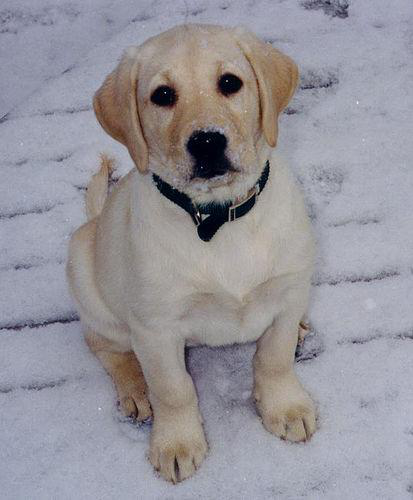

In [0]:
from PIL import Image
im = Image.open("Images/n02099712-Labrador_retriever/n02099712_6275.jpg"); im

In [0]:
bs = 128

In [0]:
np.random.seed(2)
pat = r'/n\d+-(.+)\/n\d+_\d+.jpg$'

In [0]:
data = ImageList.from_folder(path).split_by_rand_pct().label_from_re(pat).transform(get_transforms(), size=64).databunch(bs=bs).normalize(imagenet_stats)

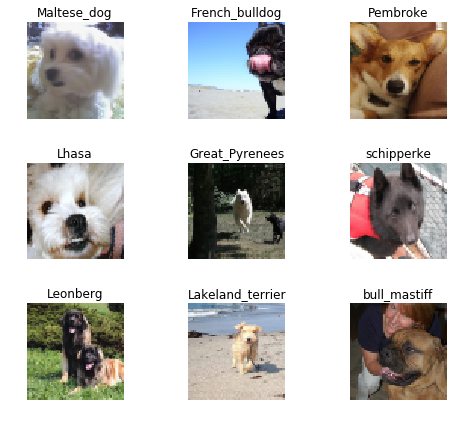

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

(120, 120)

## Custom head

In [0]:
from fastai.vision.learner import cnn_config

To be able to export to ONNX and use the exported model with `onnxjs`, we must not use any layers that use [operators not supported by onnxjs](https://github.com/microsoft/onnxjs/blob/master/docs/operators.md). `fastai` has a custom `Flatten` layer that uses one such unsupported operator, so we need to replace this with `nn.Flatten`. The below functions are basically copies of the `fastai` function, just in `create_head` I replaced `Flatten` with `nn.Flatten` to make the `onnxjs` import work.

In [0]:
def create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, nn.Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def create_cnn_model(base_arch:Callable, nc:int, cut:Union[int,Callable]=None, pretrained:bool=True,
                     lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                     bn_final:bool=False, concat_pool:bool=True):
    "Create custom convnet architecture"
    body = create_body(base_arch, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, nc, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
    else: head = custom_head
    return nn.Sequential(body, head)

def cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                split_on:Optional[SplitFuncOrIdxList]=None, bn_final:bool=False, init=nn.init.kaiming_normal_,
                concat_pool:bool=True, **kwargs:Any)->Learner:
    "Build convnet style learner."
    meta = cnn_config(base_arch)
    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
        bn_final=bn_final, concat_pool=concat_pool)
    learn = Learner(data, model, **kwargs)
    learn.split(split_on or meta['split'])
    if pretrained: learn.freeze()
    if init: apply_init(model[1], init)
    return learn

## Google Drive helper

You can always download files saved in `/content/` under the "Files" tab right inside Google Colab (you may need to click the little arrow on the left of the screen first to show the panel). But sometimes it's just more convenient to be able to save files to Google drive and copy them from there. You can moun the drive with the following code:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!mkdir -p /content/drive/My Drive/stanford-dogs

## Training: resnet18

To train faster and get better results, we use progressive image resizing, which is a fancy term for training on 64x64 px images, then 128x128, then 256x256 and finally 299x299.

### 64x64 px

In [0]:
bs=2048 # this batch size works for about 11GB of GPU RAM (Google Colab)
np.random.seed(2)
pat = r'/n\d+-(.+)\/n\d+_\d+.jpg$'

In [0]:
data = ImageList.from_folder(path).split_by_rand_pct().label_from_re(pat).transform(get_transforms(), size=64).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


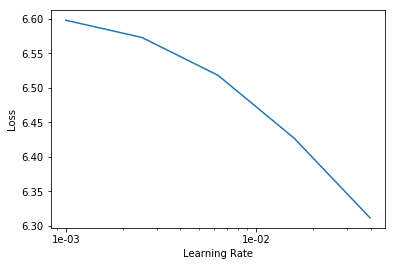

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25, 1e-2, callbacks=[EarlyStoppingCallback(learn, patience=3, min_delta=0.01)])

epoch,train_loss,valid_loss,error_rate,time
0,6.402373,6.189895,0.972546,02:29
1,6.023643,4.757359,0.918124,02:28
2,5.558844,4.426210,0.840622,02:28
3,5.120273,4.486140,0.793732,02:30
4,4.710025,4.218012,0.779883,02:29
5,4.348283,3.682412,0.756560,02:29
6,4.042309,3.392395,0.741740,02:30
7,3.786223,3.012309,0.715500,02:31
8,3.563122,2.764931,0.693635,02:31
9,3.377573,2.646423,0.665452,02:31


In [0]:
learn.save('/content/resnet18-size64x64-bs2048-stage1')

In [0]:
learn.load('/content/resnet18-size64x64-bs2048-stage1');

### 128x128 px

In [0]:
bs=1024
data = ImageList.from_folder(path).split_by_rand_pct().label_from_re(pat).transform(get_transforms(), size=128).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


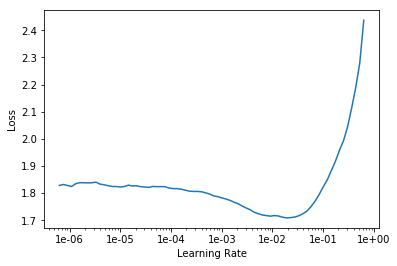

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, 1e-3, callbacks=[EarlyStoppingCallback(learn, patience=3, min_delta=0.01)])

epoch,train_loss,valid_loss,error_rate,time
0,1.807577,1.384291,0.386783,03:45
1,1.785056,1.388487,0.388241,03:45
2,1.762584,1.342601,0.377551,03:45
3,1.725255,1.285214,0.367104,03:45
4,1.675982,1.233782,0.355442,03:46
5,1.620322,1.190012,0.342080,03:45
6,1.565026,1.155626,0.333576,03:46
7,1.511039,1.129515,0.325316,03:46
8,1.456771,1.107357,0.317055,03:45
9,1.408666,1.086744,0.313168,03:46


Epoch 21: early stopping


In [0]:
learn.save('/content/resnet18-size128x128-bs1024-stage1')

In [0]:
learn.load('/content/resnet18-size128x128-bs1024-stage1');

### 256x256 px

In [0]:
bs=256
data = ImageList.from_folder(path).split_by_rand_pct().label_from_re(pat).transform(get_transforms(), size=256).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


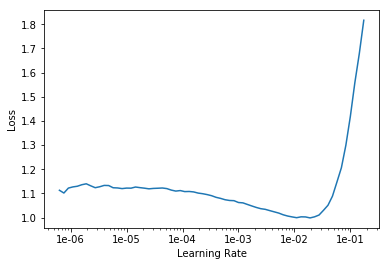

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(30, 1e-3, callbacks=[EarlyStoppingCallback(learn, patience=3, min_delta=0.01)])

epoch,train_loss,valid_loss,error_rate,time
0,1.049372,0.637193,0.205782,05:19
1,0.947288,0.568290,0.181730,05:18
2,0.851249,0.525046,0.168124,05:19
3,0.776426,0.502814,0.161565,05:21
4,0.708373,0.487449,0.158163,05:18
5,0.666550,0.483616,0.156706,05:22
6,0.640309,0.480812,0.156220,05:22
7,0.609370,0.478977,0.153304,05:19
8,0.577301,0.472579,0.152089,05:14
9,0.548303,0.475261,0.154033,05:17


Epoch 12: early stopping


In [0]:
learn.save('/content/drive/My Drive/stanford-dogs/resnet18-size256x256-bs256-stage1')

In [0]:
learn.load('/content/drive/My Drive/stanford-dogs/resnet18-size256x256-bs256-stage1');

### 299x299 px

In [0]:
bs=128
data = ImageList.from_folder(path).split_by_rand_pct().label_from_re(pat).transform(get_transforms(), size=299).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


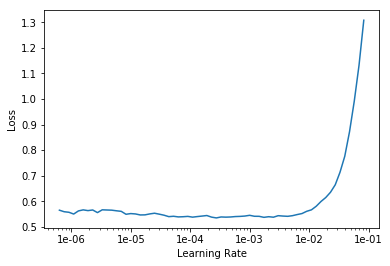

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, 1e-3, callbacks=[EarlyStoppingCallback(learn, patience=3, min_delta=0.01)])

epoch,train_loss,valid_loss,error_rate,time
0,0.524296,0.286573,0.086006,06:21
1,0.506252,0.291439,0.089407,06:21
2,0.505738,0.320690,0.099854,06:18
3,0.512005,0.342673,0.113946,06:24


Epoch 4: early stopping


In [0]:
learn.save('/content/drive/My Drive/stanford-dogs/resnet18-size299x299-bs128-stage1')

In [0]:
learn.load('/content/drive/My Drive/stanford-dogs/resnet18-size256x256-bs256-stage1');

In [0]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.550403,0.310203,0.097182,06:22


In [0]:
learn.save('/content/drive/My Drive/stanford-dogs/resnet18-size299x299-bs128-stage1_1epoch')

### Export to ONNX

For export, we put the model in evaluation mode.

In [0]:
learn.model.eval();

The way PyTorch's export works, we need to give a tensor of the correct shape to the model. The model will then run (inference) and while doing so, all operations are recorded and can then be saved to the ONNX format.

In [0]:
x = torch.randn(1, 3, 299, 299, requires_grad=False).cuda()
torch_out = torch.onnx._export(learn.model, x, "/content/drive/My Drive/stanford-dogs/dogs-resnet18.onnx", export_params=True)